In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time
import os
import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.fit import plot_all_losses

import yaml

In [3]:
from os.path import exists, join, splitext

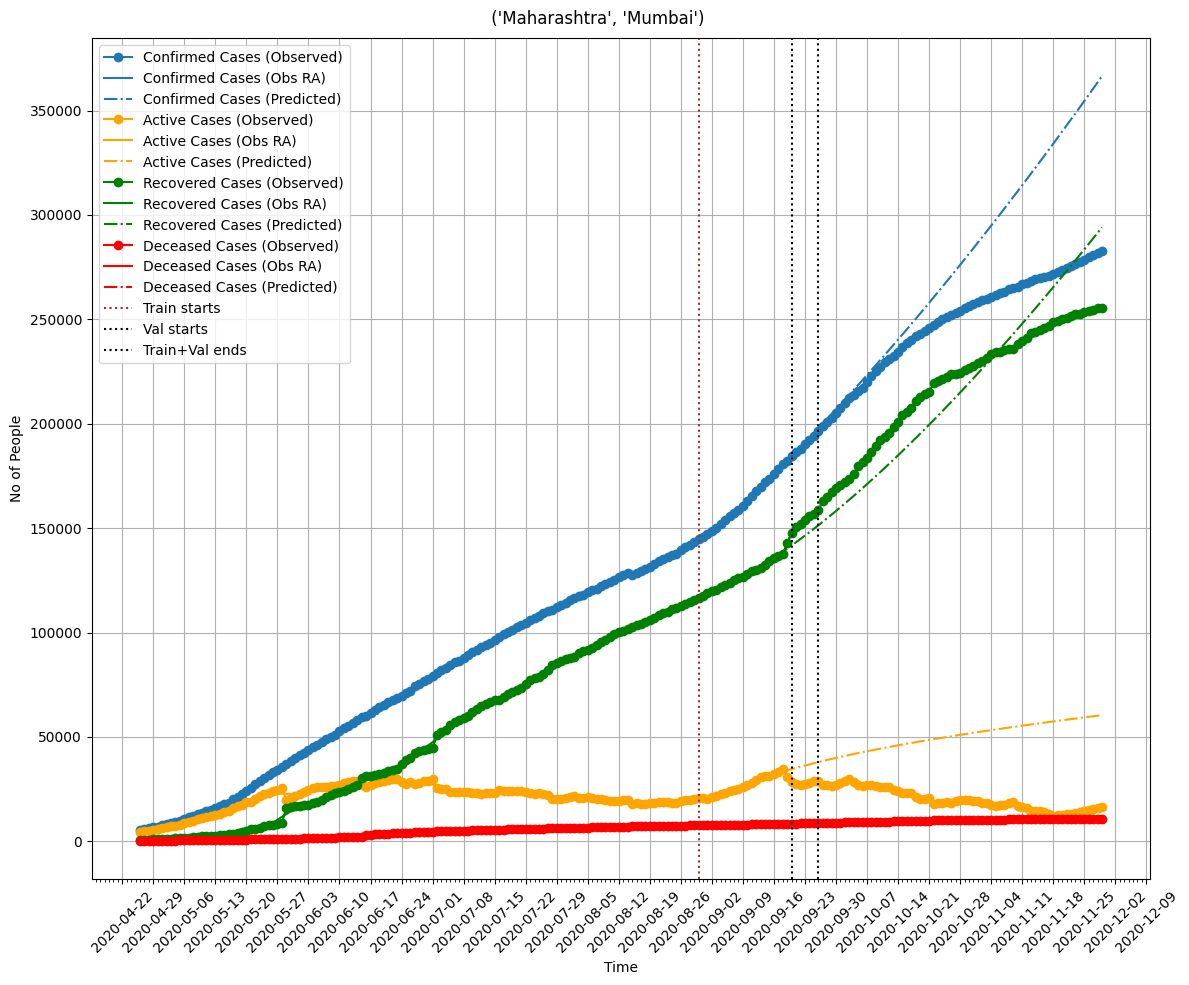

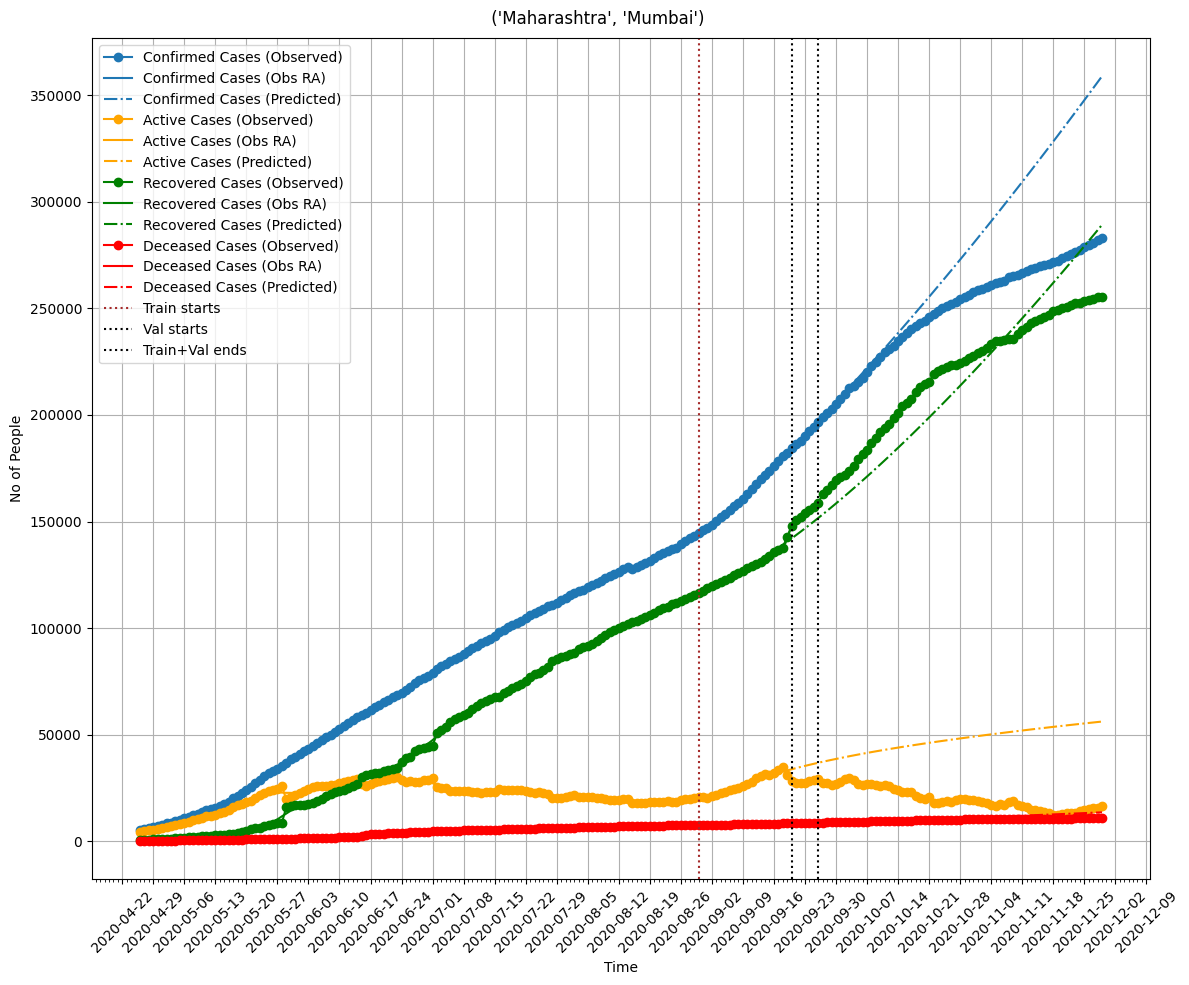

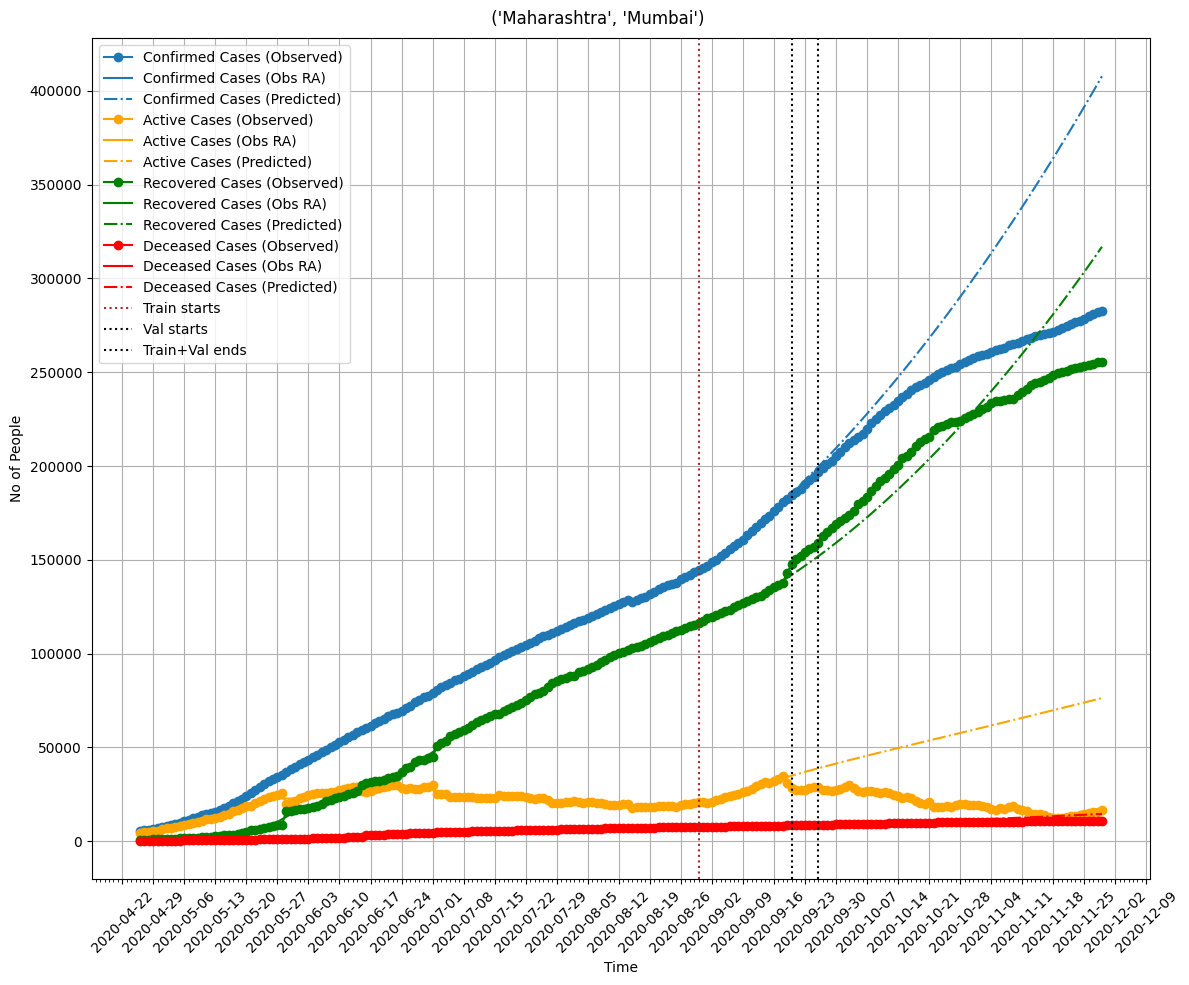

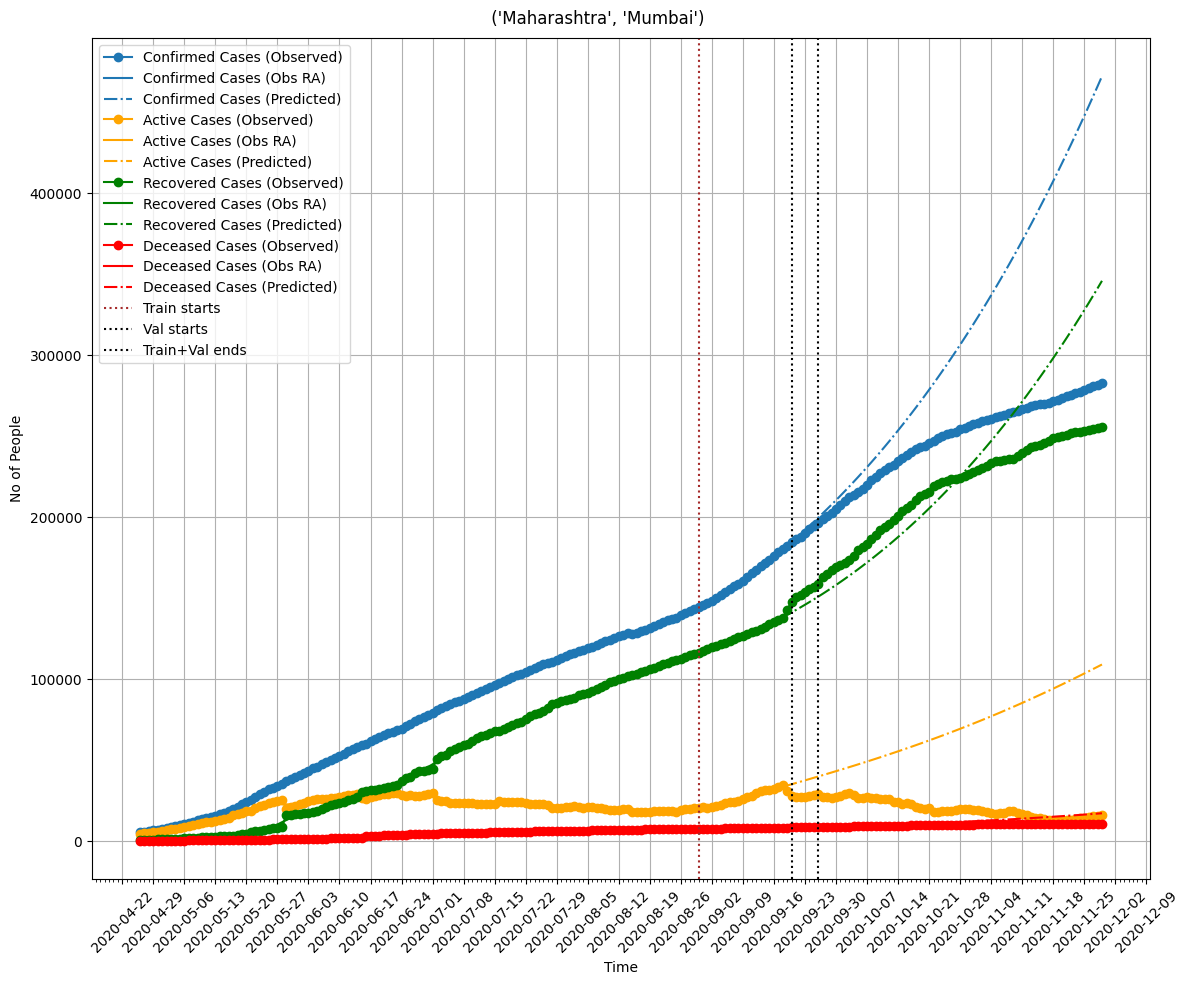

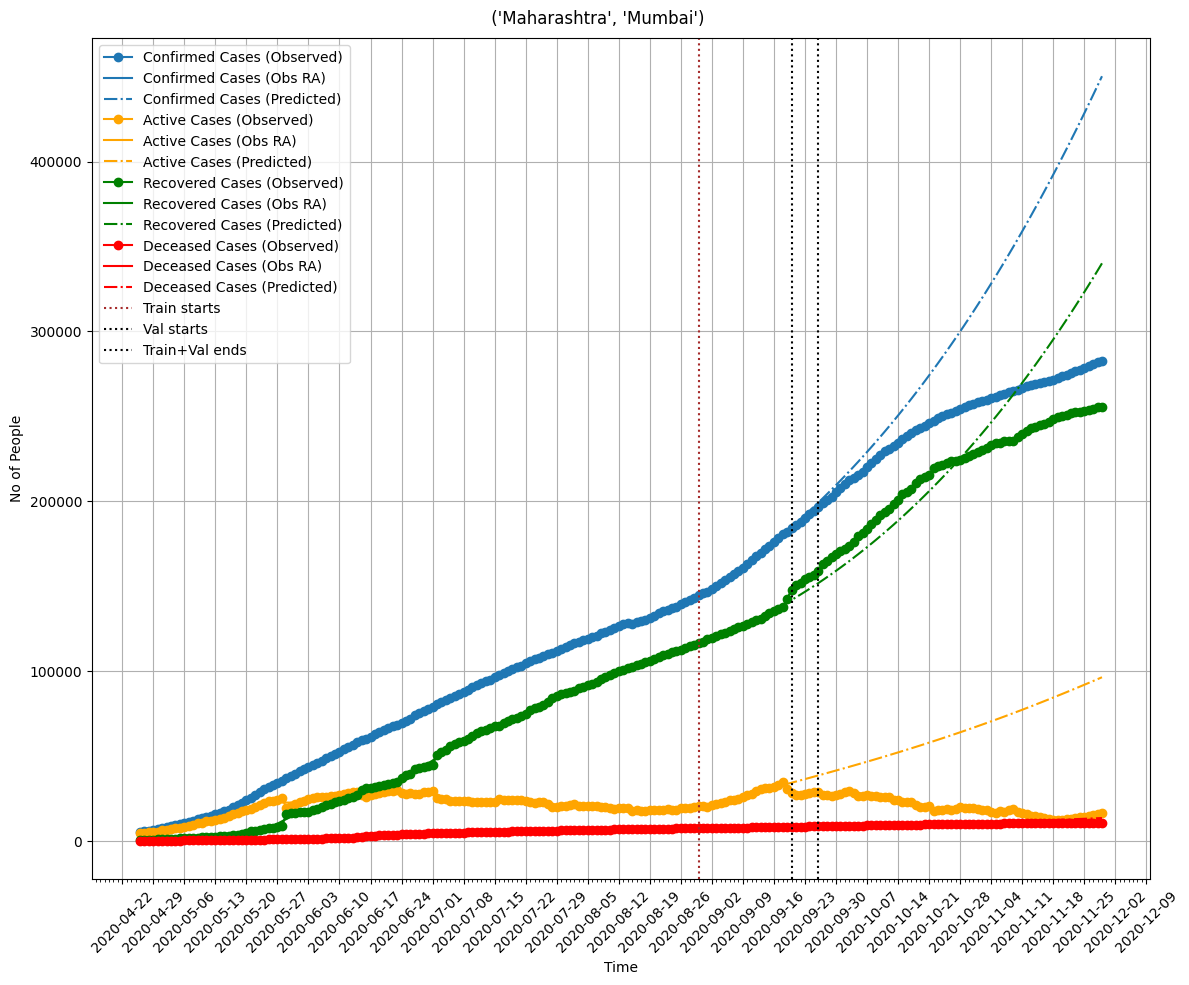

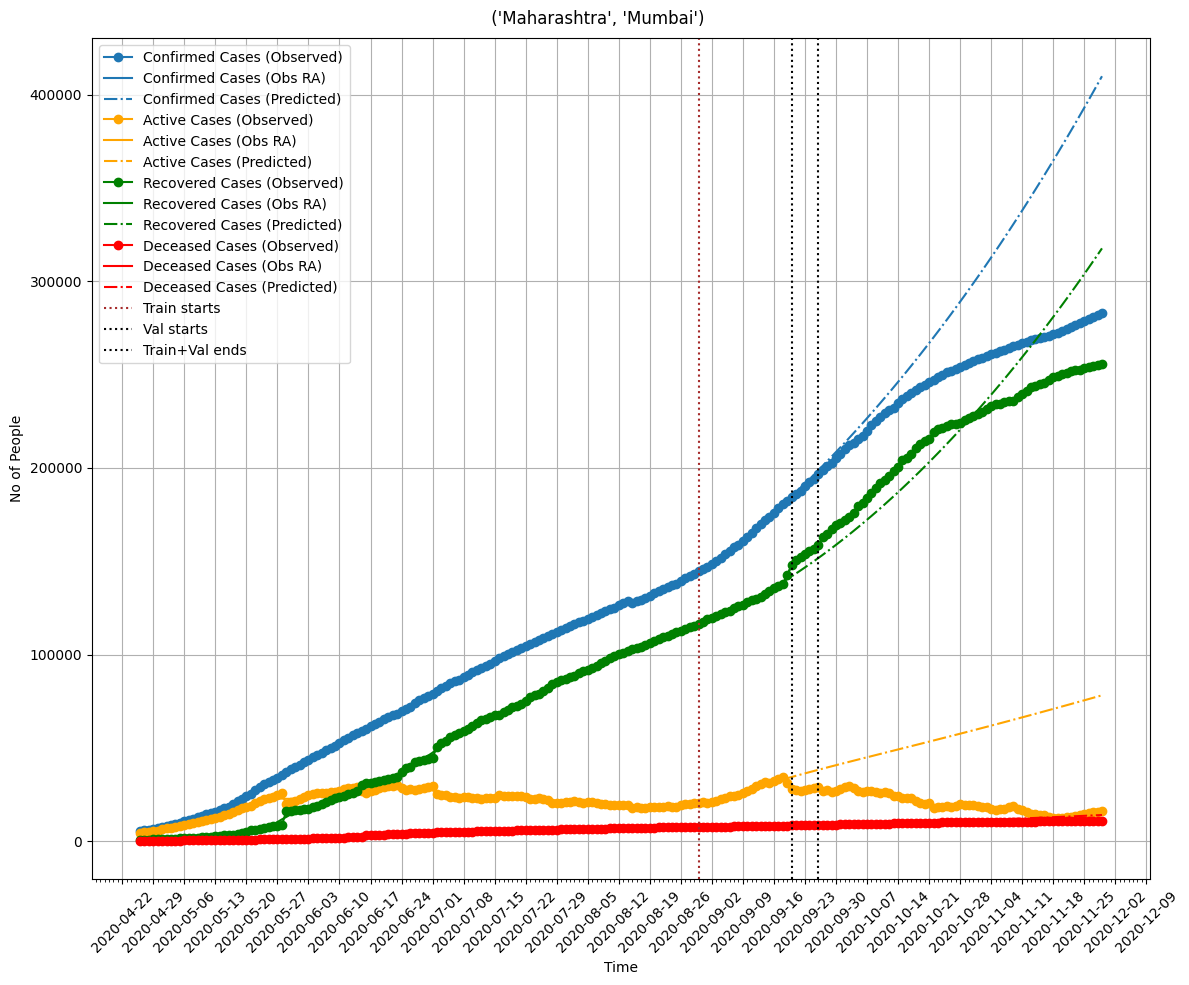

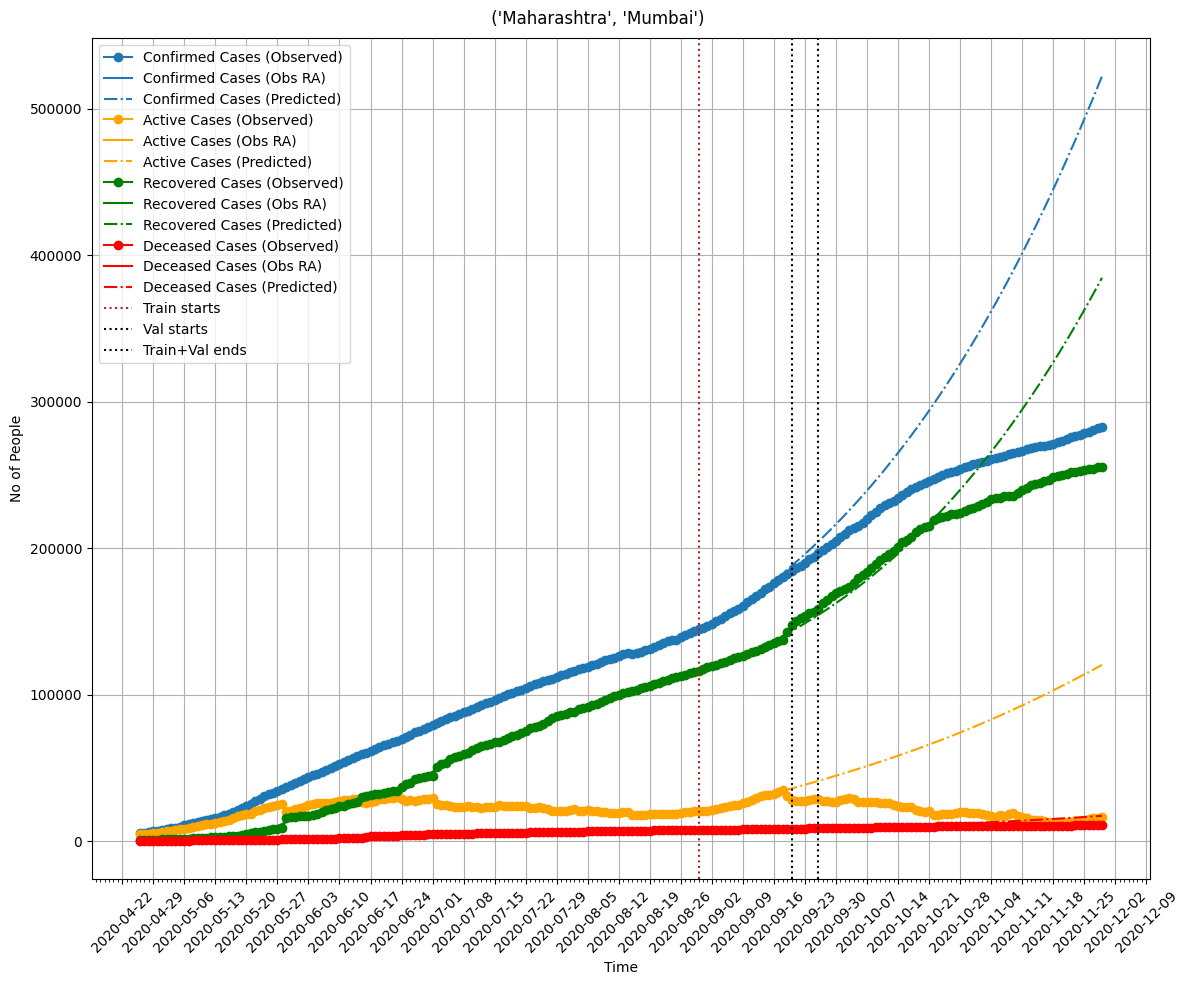

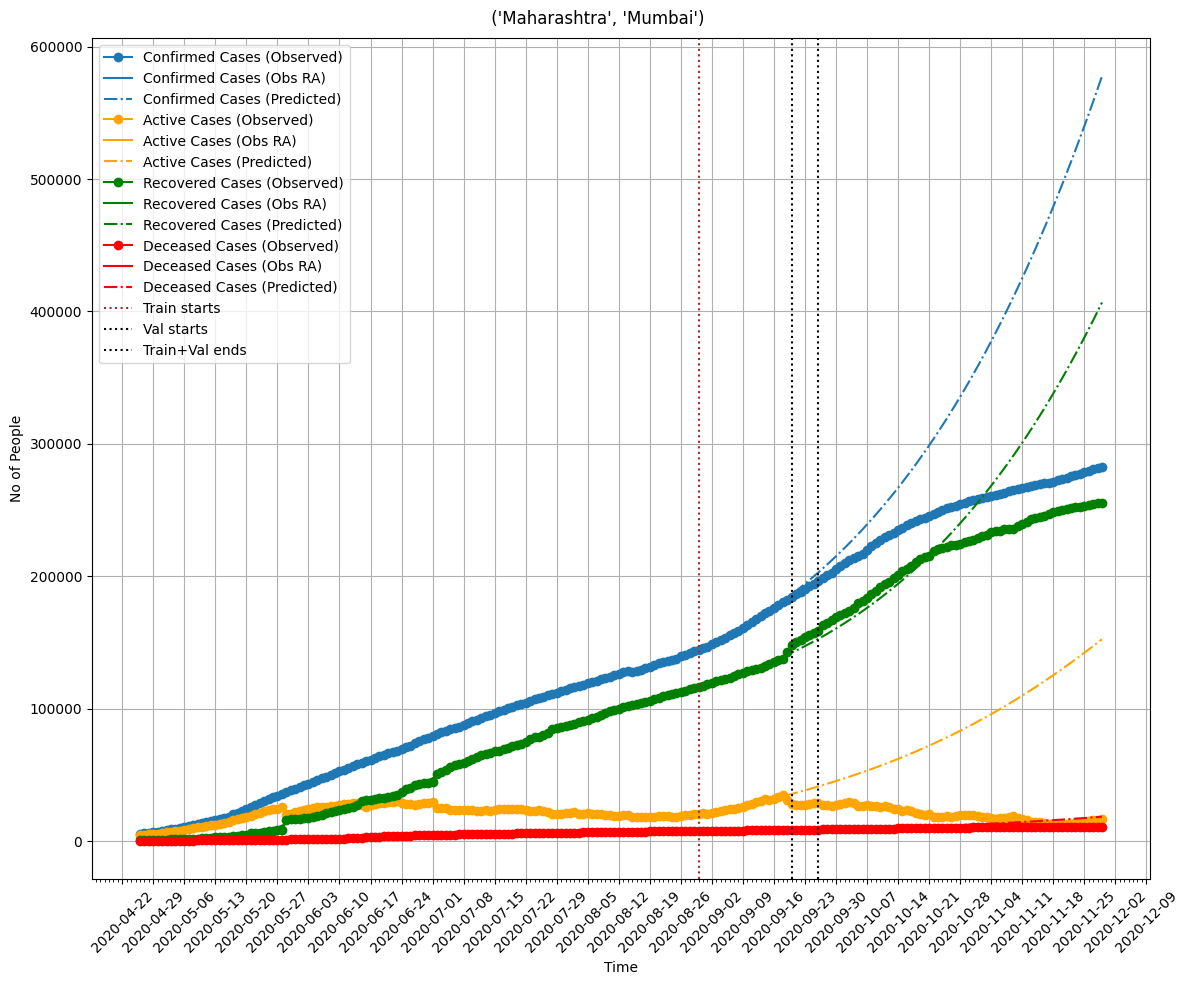

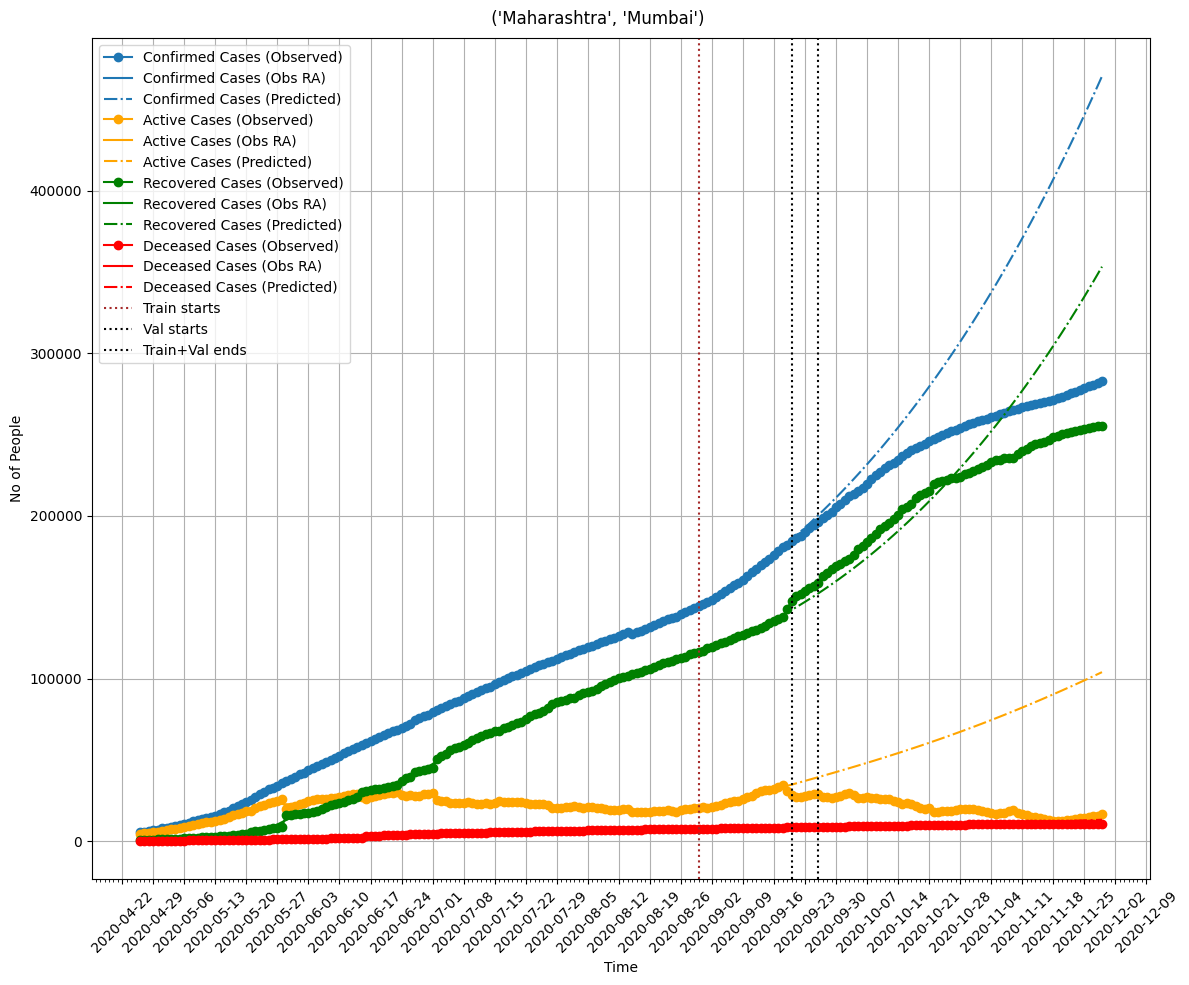

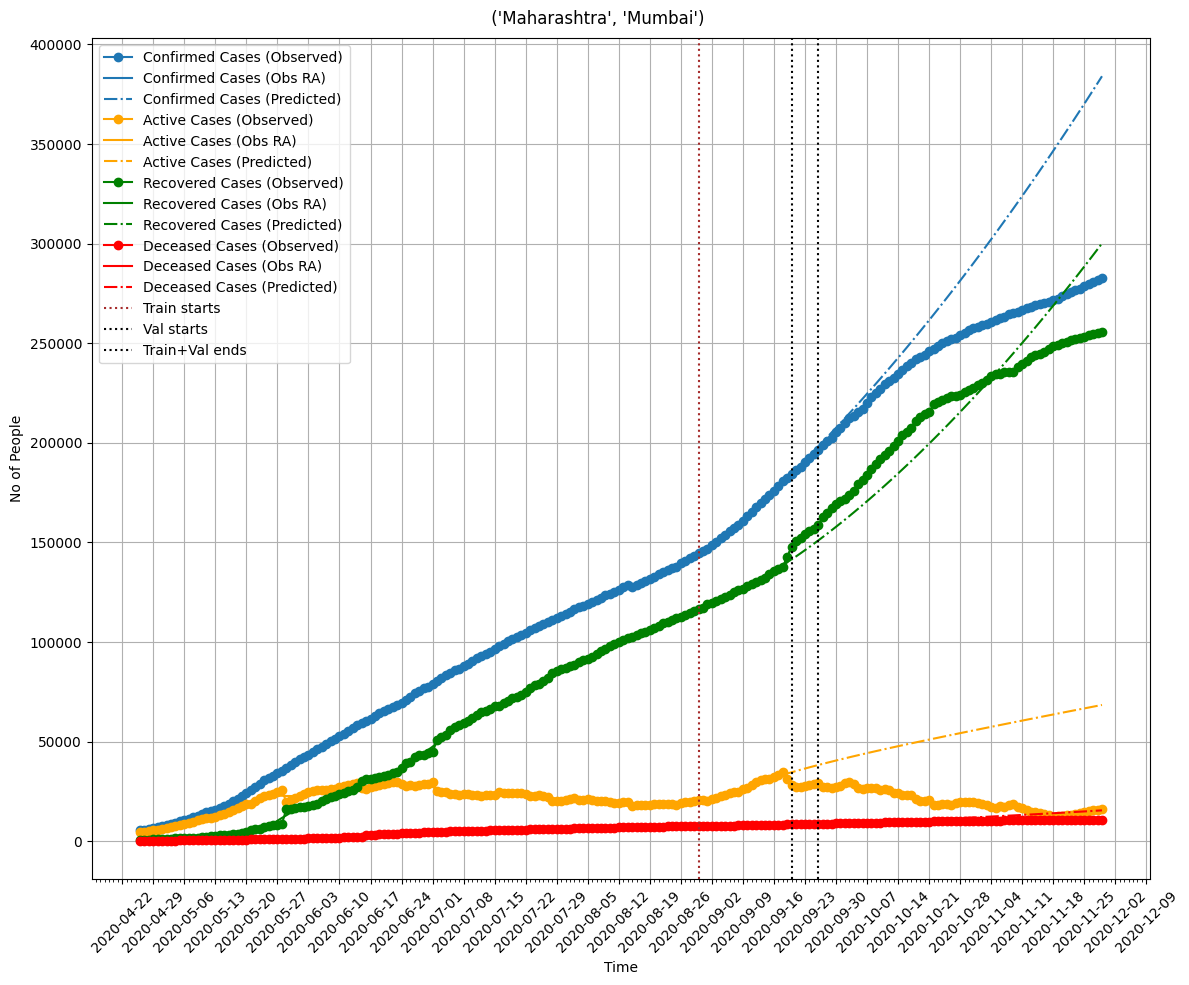

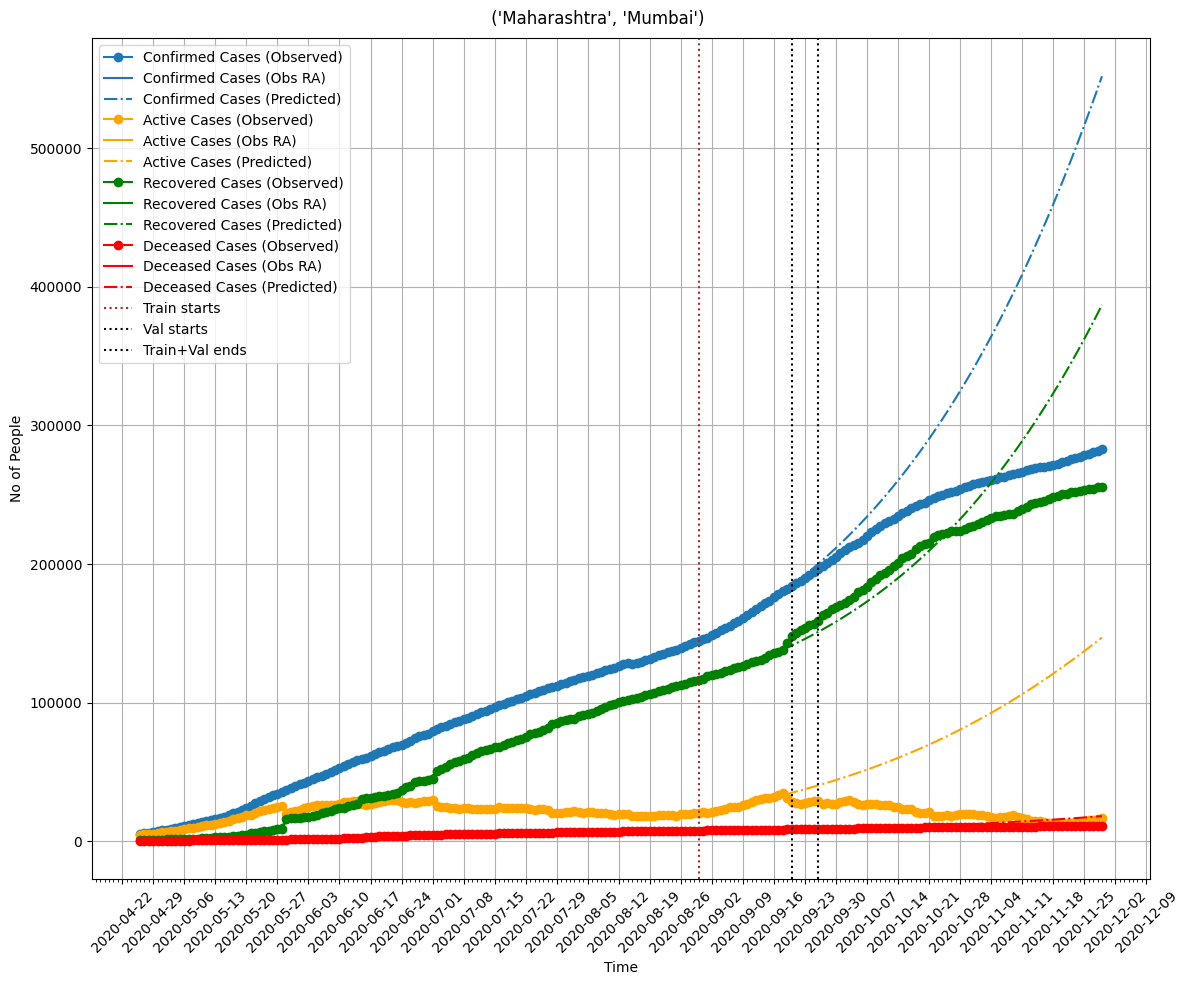

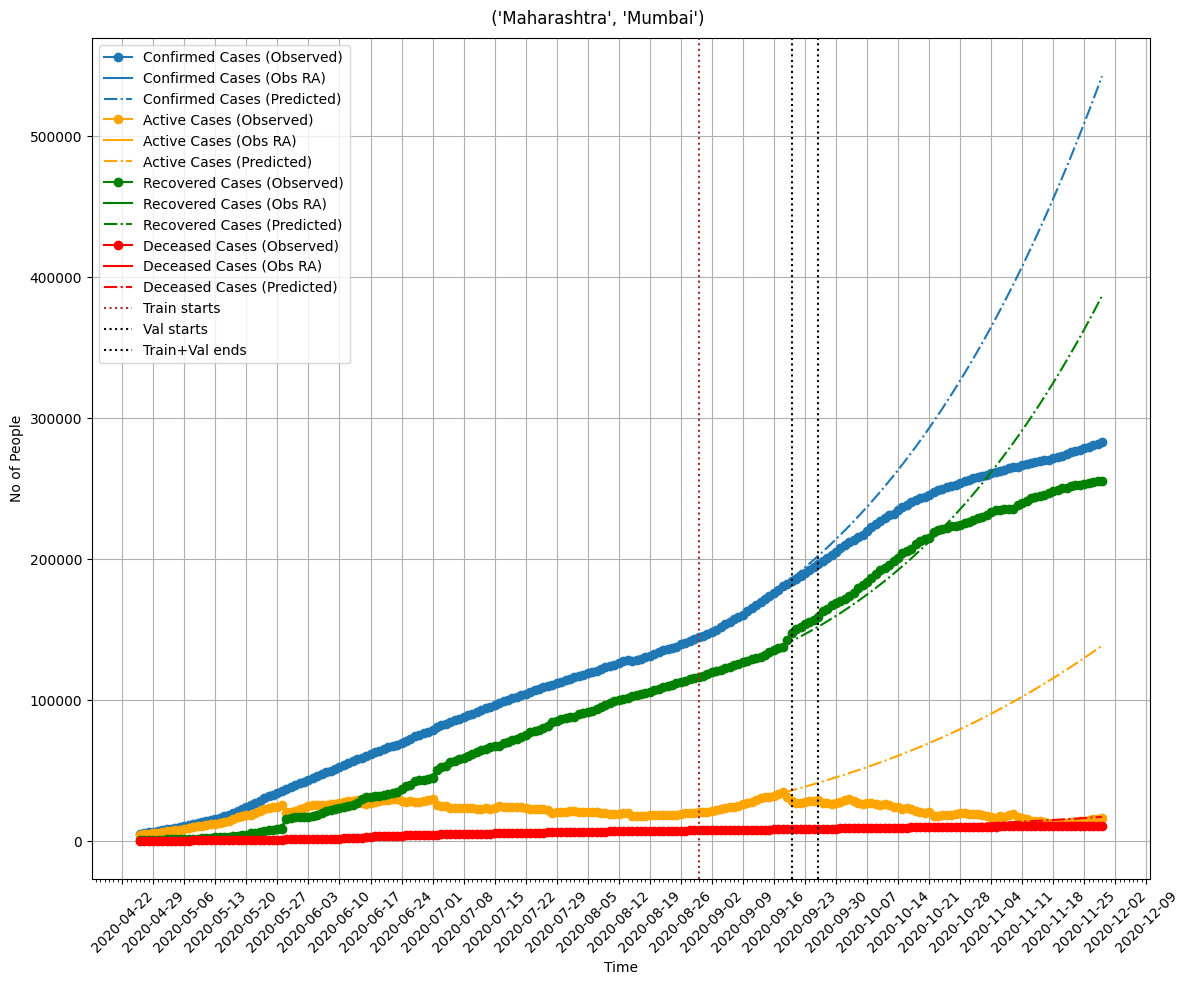

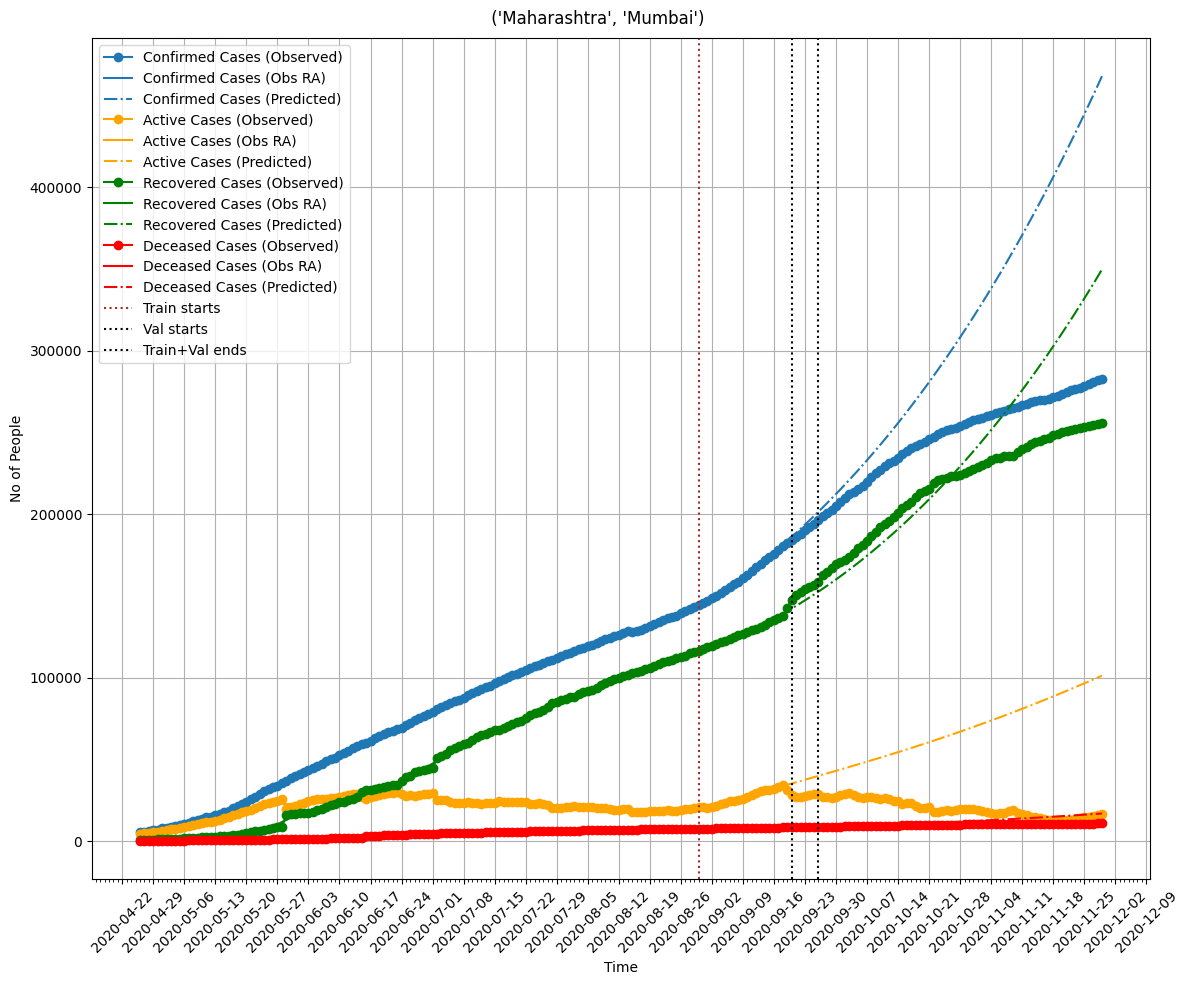

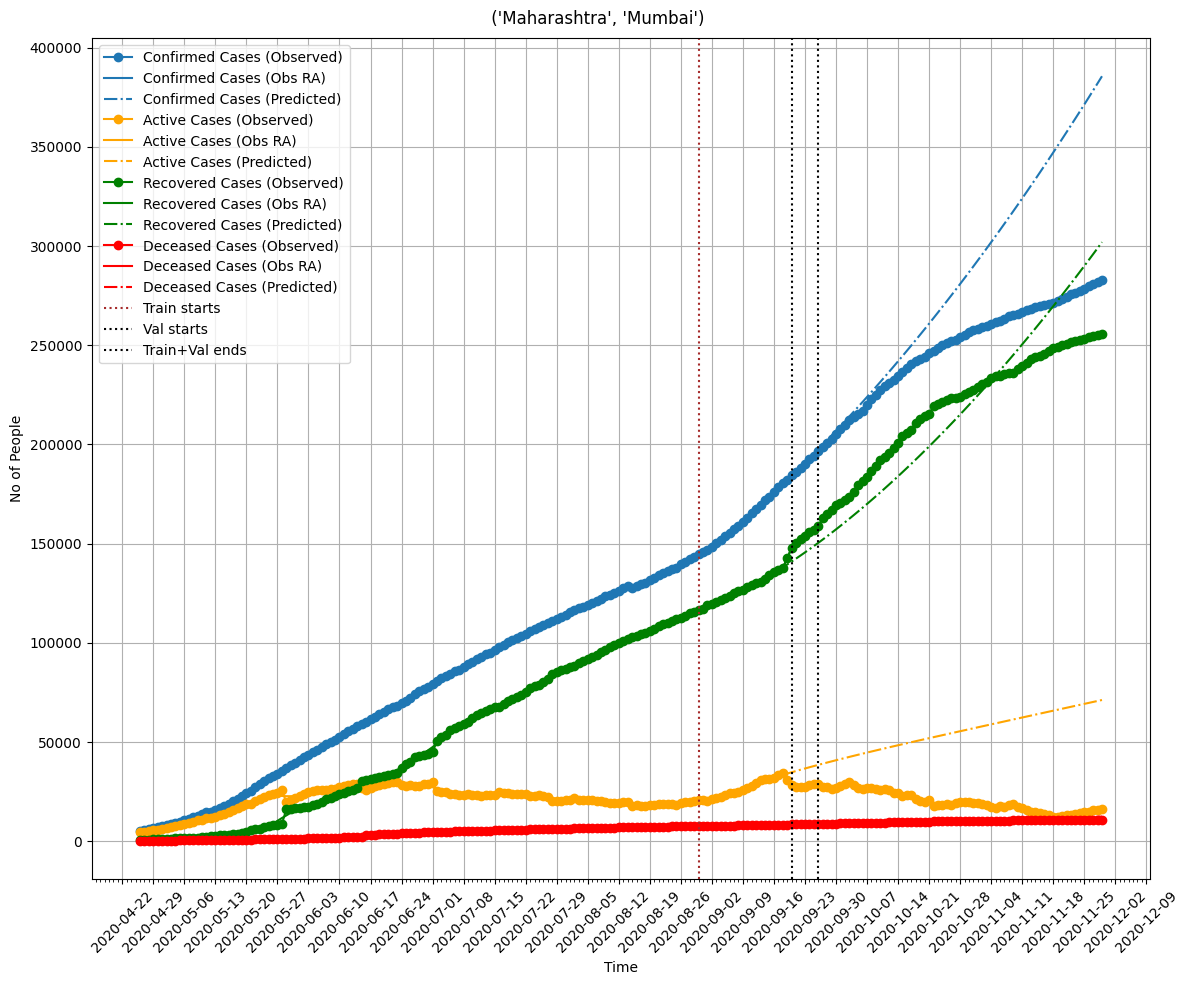

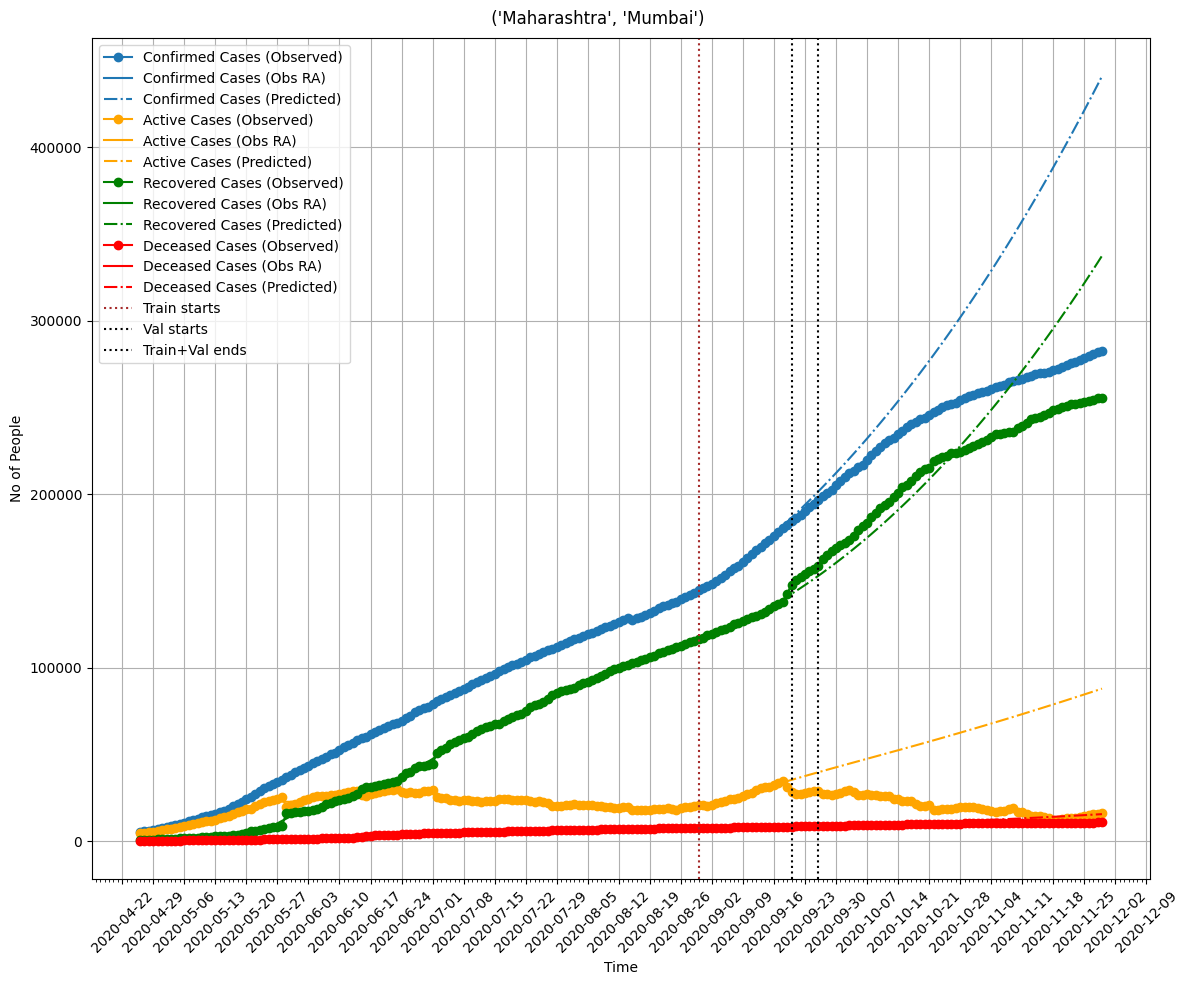

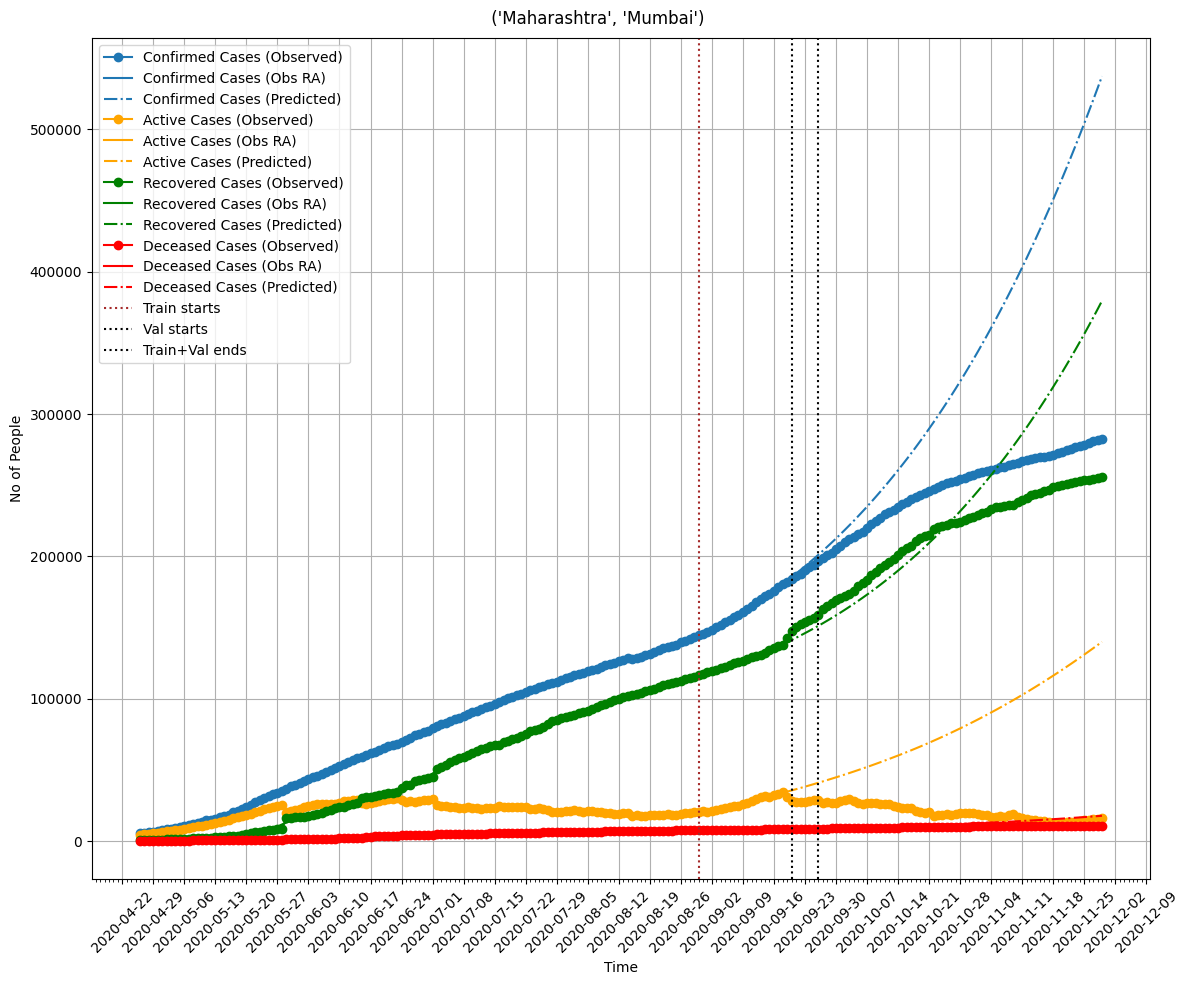

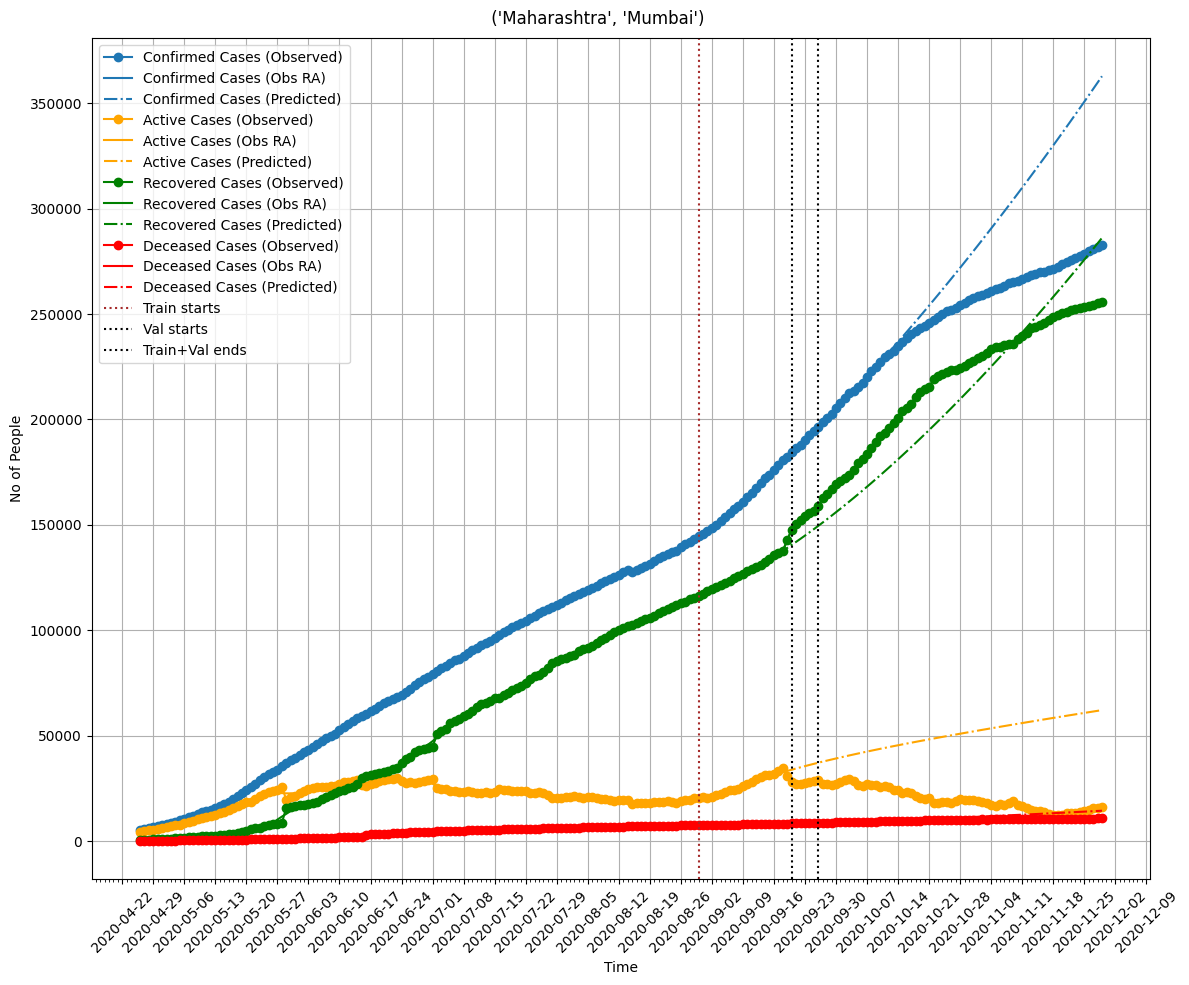

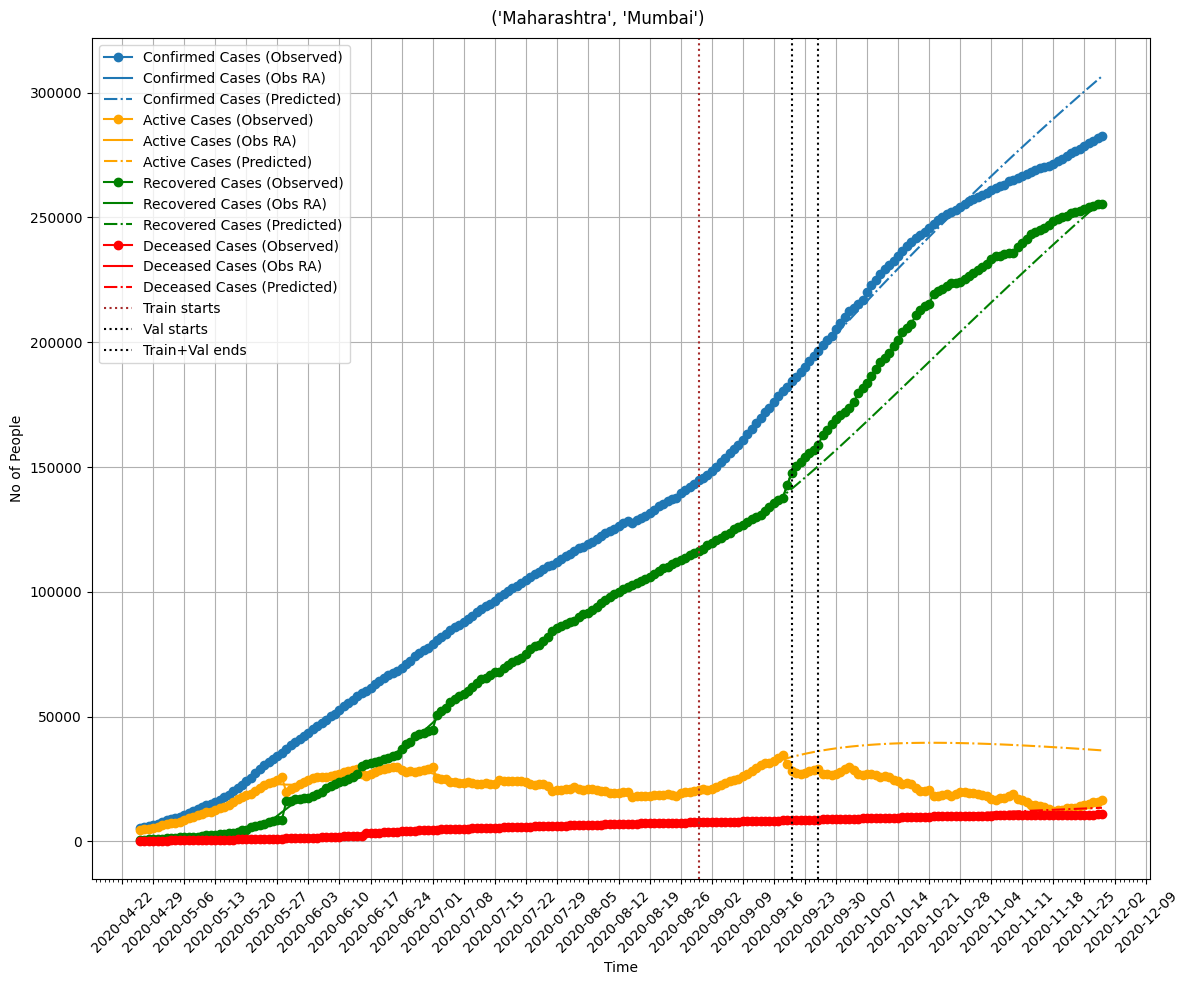

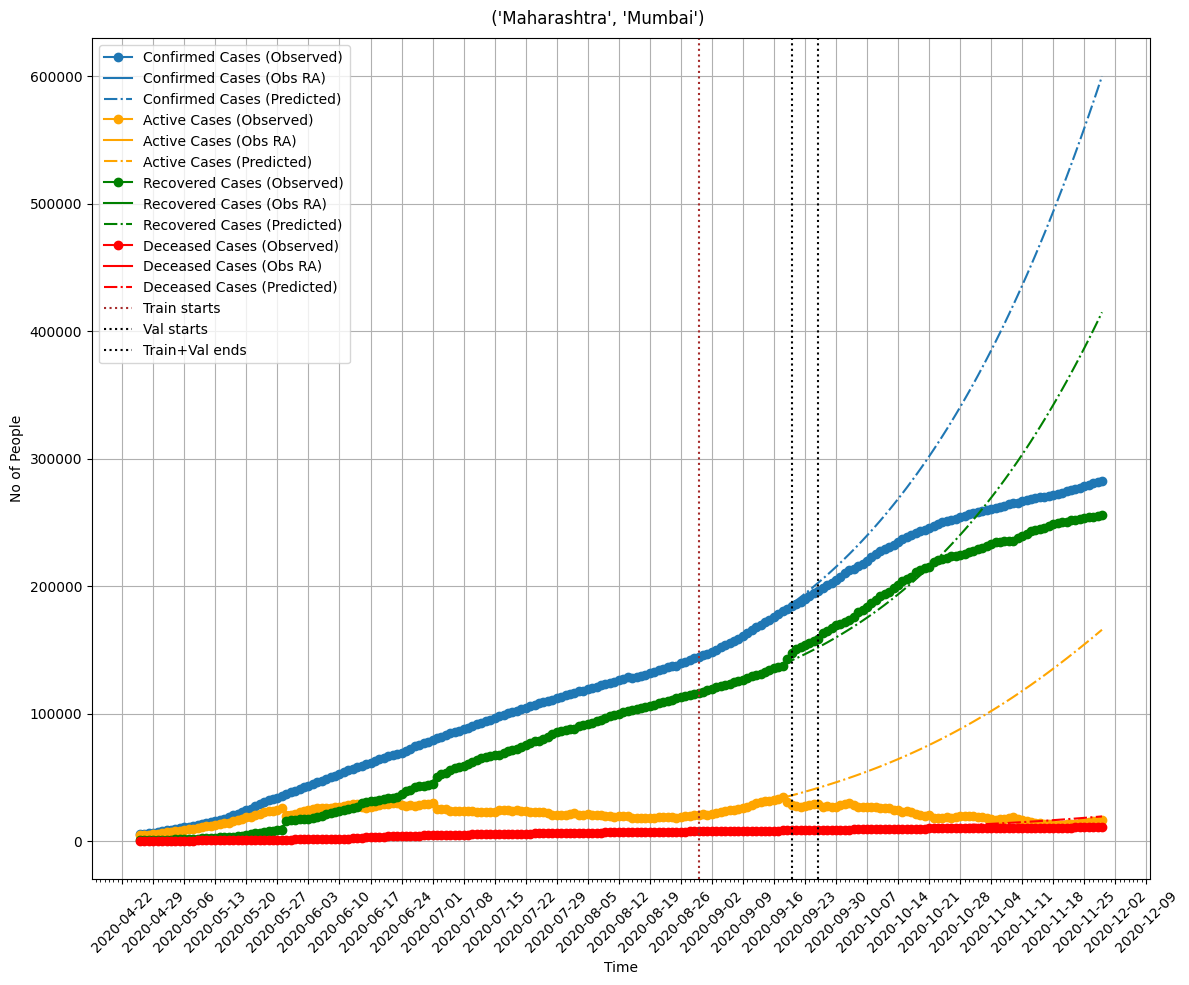

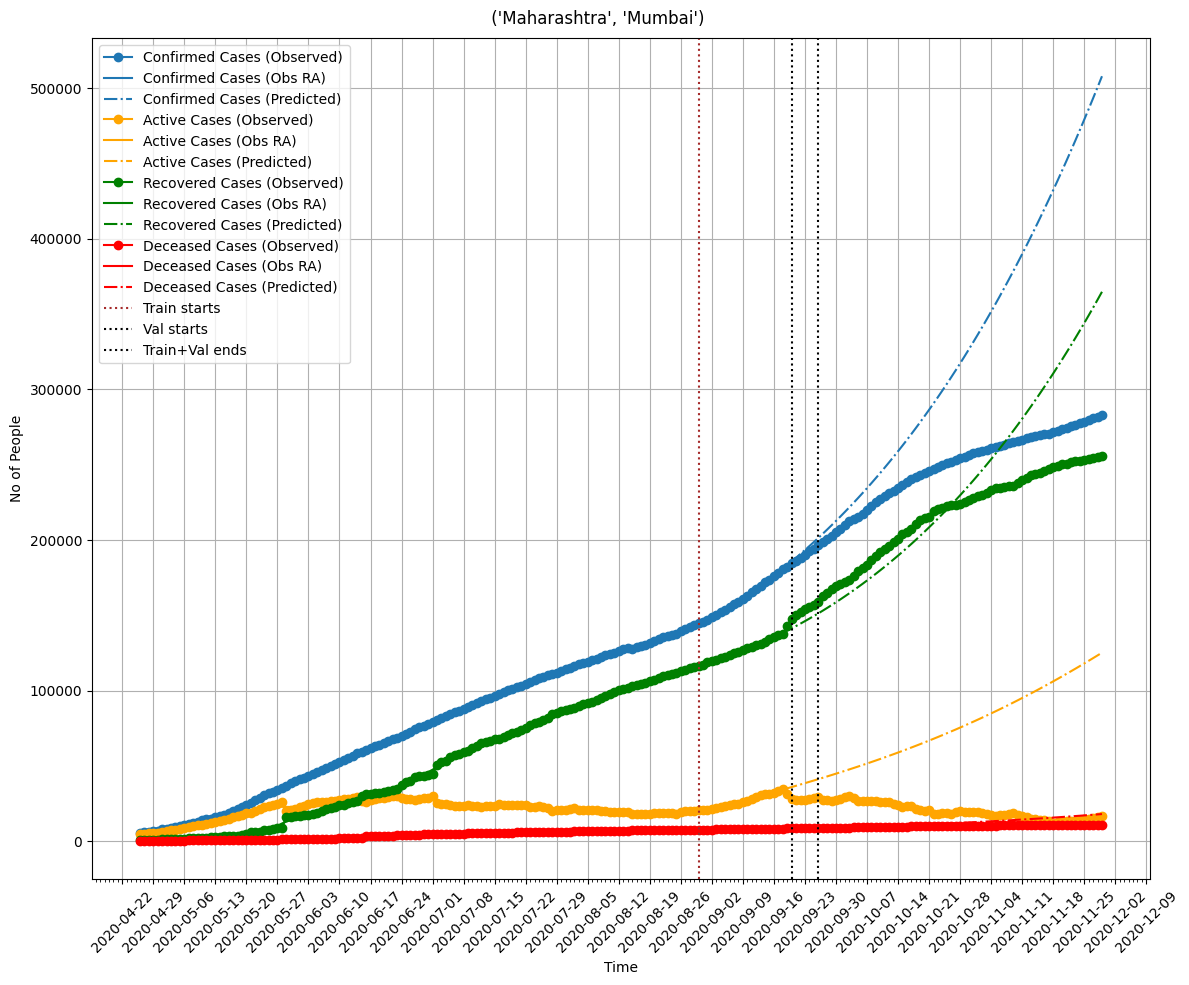

In [4]:
import pickle as pkl
with open('../../misc/predictions/PD_sep_10.pickle', 'rb') as handle:
    PD = pkl.load(handle)

In [5]:
import pandas as pd
pd.DataFrame(PD['m0']['MCMC']['ensemble_mean_forecast']['df_loss'],index = [0])

active  recovered   deceased    total
0  22.489386    5.52533  13.820845  0.53303

In [6]:
which_compartments = ['total', 'active', 'recovered', 'deceased','agg']

In [13]:
df_compiled = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['df_loss']['val']
        df['agg'] = df.mean()
        df_compiled[model].append(df)
        

In [14]:
df_compiled['MCMC'][0]

total          1.8602
active        9.61393
recovered    0.808251
deceased      2.03338
agg           3.57894
Name: val, dtype: object

In [15]:
import pandas as pd
stats = {}
stats['MCMC'] = (pd.DataFrame(df_compiled['MCMC']).describe()).loc[['mean','std']]
stats['BO'] = (pd.DataFrame(df_compiled['BO']).describe()).loc[['mean','std']]

In [16]:
stats['MCMC'].loc[['mean']]

total    active  recovered  deceased       agg
mean  1.664804  9.714016   0.560357  1.318715  3.314473

## Comparing best loss from MCMC vs BO

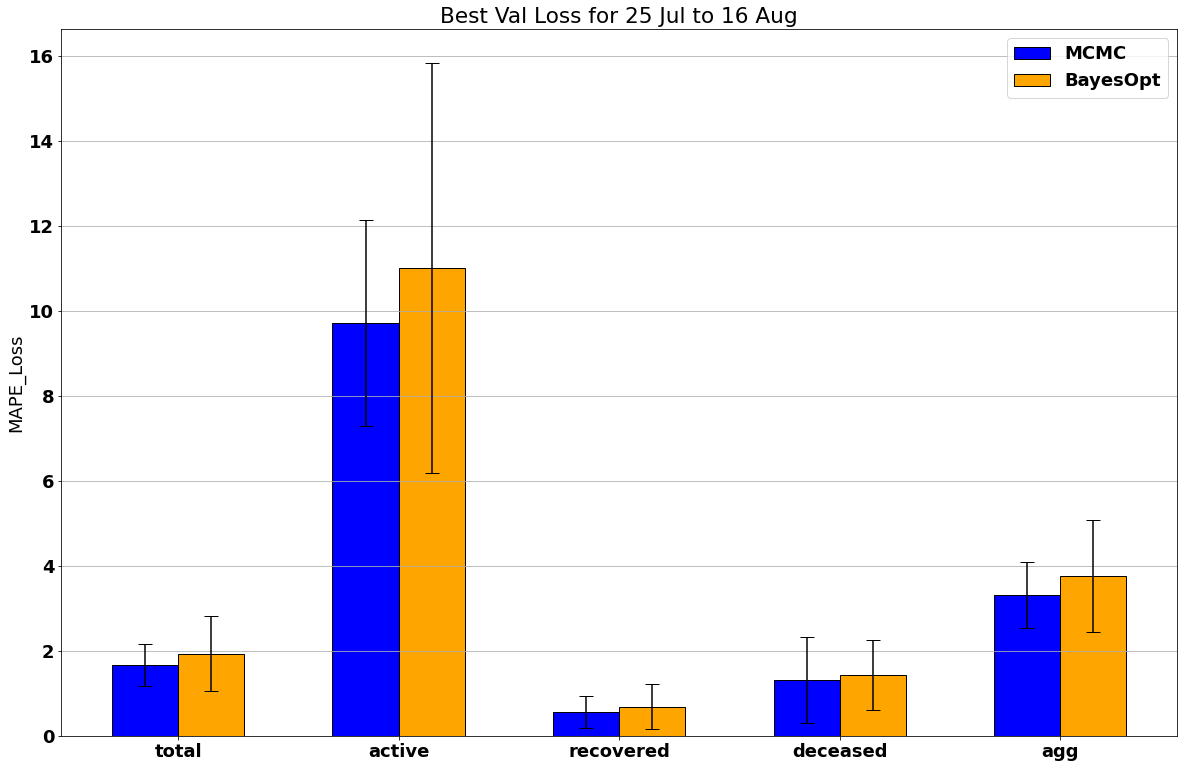

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
barWidth = 0.3
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)

plt.figure(figsize=(20,13))
# Choose the height of the blue bars
bars1 = stats['MCMC'].loc[['mean']].values[0]
 
# Choose the height of the cyan bars
bars2 = stats['BO'].loc[['mean']].values[0]
 
# Choose the height of the error bars (bars1)
yer1 = stats['MCMC'].loc[['std']].values[0]
 
# Choose the height of the error bars (bars2)
yer2 = stats['BO'].loc[['std']].values[0]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], which_compartments)
plt.ylabel('MAPE_Loss')
plt.title('Best Val Loss for 25 Jul to 16 Aug')
plt.legend()
 
# Show graphic
plt.show()


## Comparing Ensemble loss from MCMC vs BO

In [18]:
df_compiled_ens = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['ensemble_mean_forecast']['df_loss']
        df['agg'] = np.mean(list(df.values()))
        df2 = {comp:df[comp] for comp in which_compartments}
        df_compiled_ens[model].append(df2)

In [19]:
import pandas as pd
stats_ens = {}
stats_ens['MCMC'] = (pd.DataFrame(df_compiled_ens['MCMC']).describe()).loc[['mean','std']]
stats_ens['BO'] = (pd.DataFrame(df_compiled_ens['BO']).describe()).loc[['mean','std']]

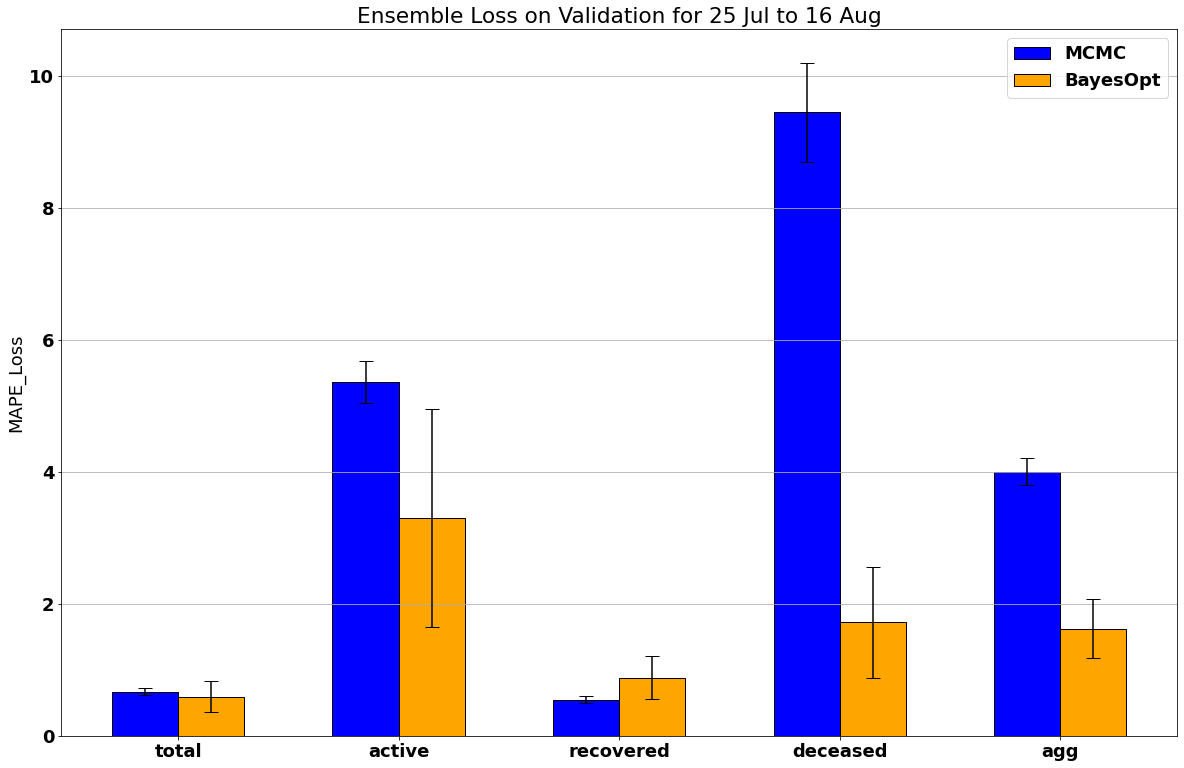

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
barWidth = 0.3
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)

plt.figure(figsize=(20,13))
# Choose the height of the blue bars
bars1 = stats_ens['MCMC'].loc[['mean']].values[0]
 
# Choose the height of the cyan bars
bars2 = stats_ens['BO'].loc[['mean']].values[0]
 
# Choose the height of the error bars (bars1)
yer1 = stats_ens['MCMC'].loc[['std']].values[0]
 
# Choose the height of the error bars (bars2)
yer2 = stats_ens['BO'].loc[['std']].values[0]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], which_compartments)
plt.ylabel('MAPE_Loss')
plt.title('Ensemble Loss on Validation for 25 Jul to 16 Aug')
plt.legend()
 
# Show graphic
plt.show()

## DIC 

In [11]:
df_compiled_DIC = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['metric']['DIC']
        df_compiled_DIC[model].append(df)
df_compiled_DIC

{'MCMC': [11.464682754571221,
  10.306892426407957,
  10.258408752430633,
  10.323786655015667,
  10.229232146921941,
  10.238258674607502,
  10.27388349760977,
  10.454286987278707,
  10.106625421987701,
  11.703650983239402],
 'BO': [6.2699246042134344,
  6.746396410613436,
  6.671812679733434,
  6.677856917066768,
  6.388535113333434,
  6.474513551200099,
  6.416442998346769,
  6.261435001226768,
  6.3076812667201025,
  6.3173833541867666]}

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


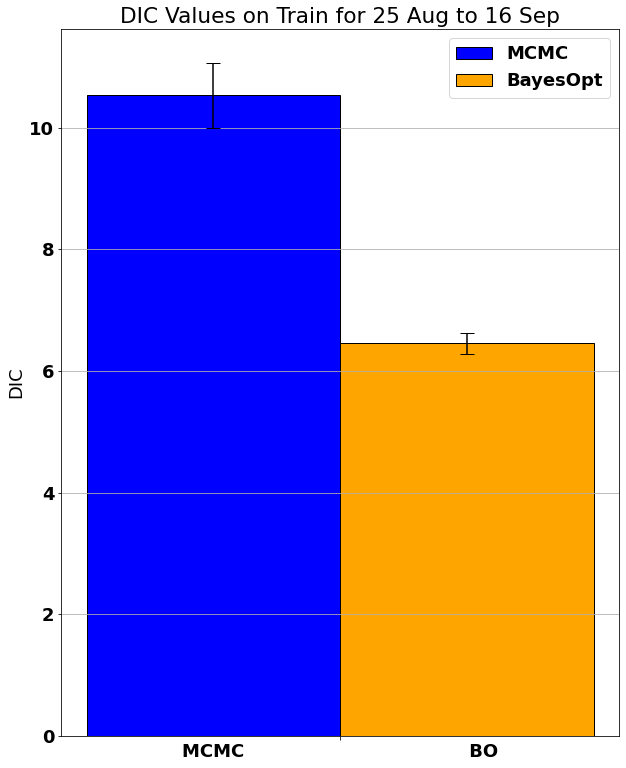

In [12]:
barWidth = 0.3
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)

plt.figure(figsize=(10,13))
# Choose the height of the blue bars
bars1 = [np.mean(df_compiled_DIC['MCMC'])]
 
# Choose the height of the cyan bars
bars2 = [np.mean(df_compiled_DIC['BO'])]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(df_compiled_DIC['MCMC'])]
 
# Choose the height of the error bars (bars2)
yer2 = [np.std(df_compiled_DIC['BO'])]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['MCMC                                    BO'])
plt.ylabel('DIC')
plt.title('DIC Values on Train for 25 Aug to 16 Sep')
plt.legend()
 
# Show graphic
plt.show()

## Percentile Loss

In [6]:
df_compiled_perc_loss = {"MCMC":[],"BO":[]}
percentiles = []
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = {}
        percentiles = list(model_dict['uncertainty_forecasts'].keys())
        for perc,perc_dict in model_dict['uncertainty_forecasts'].items():
            df[perc] = perc_dict['df_loss_perc'].values[0][0]
        df_compiled_perc_loss[model].append(df)

In [7]:
stats_perc_MCMC = pd.DataFrame(df_compiled_perc_loss['MCMC']).describe().loc[['mean','std']]
stats_perc_BO = pd.DataFrame(df_compiled_perc_loss['BO']).describe().loc[['mean','std']]

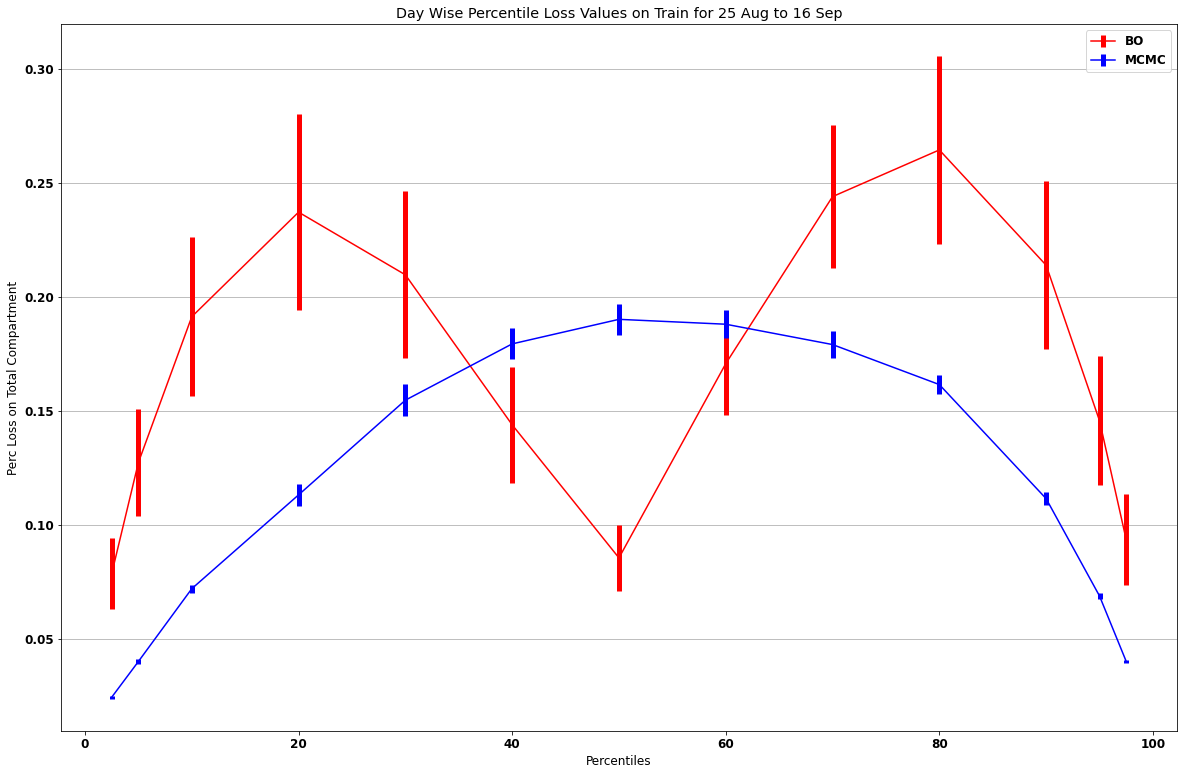

In [10]:
import matplotlib as mpl
barWidth = 0.3
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

mpl.rc('font', **font)

plt.figure(figsize=(20,13))
plt.errorbar(list(stats_perc_BO.loc['mean'].keys()),list(stats_perc_BO.loc['mean'].values),color = 'red',label='BO',yerr =list(stats_perc_BO.loc['std'].values) ,elinewidth =5,capthick =3,barsabove = True)
plt.errorbar(list(stats_perc_MCMC.loc['mean'].keys()),list(stats_perc_MCMC.loc['mean'].values),color = 'blue',label = 'MCMC',yerr = list(stats_perc_MCMC.loc['std'].values),elinewidth =5,capthick =3,barsabove = True)


# general layout
plt.grid(b = True,axis = 'y')
plt.ylabel('Perc Loss on Total Compartment')
plt.xlabel('Percentiles')
plt.title('Day Wise Percentile Loss Values on Train for 25 Aug to 16 Sep')
plt.legend()
 
# Show graphic
plt.show()